## "Sustainable Horizons: A Deep Dive into S&P 500 Companies' Eco-Practices and Leadership Views"


<b> Goal </b>: The primary goal of the project is to analyze the sustainability report of S&P 500 companies and allows user to search for queries on the text which would give the output related to concerned sector, the possible type of cluster it may belong to and also the frequency of the keyword in the leadership messages.

<b> Data Used </b>: All the reports of sustaianbility/ESG were downloaded from organization's official website.It was tried to download the latest published report. Since we are only in January, many companies have not yet released their sustainabilty report for 2023.

<b> Libraries and framework </b>: We have used Python and other NLP libraries like spacy, nltk & gensim. We have also used transformers like BERT and rule-based model for few tasks.

<b> Brief view of Program Flow </b>:
1. The texts were extracted from the PDF files.  
2. Embedding through BERT was performed for all of the rows and stored in next to these rows.
3. Next we performed K-Mean clustering algorithm to classify the reports based on the embeddings that we had.
4. To get the primary themes out of the text, we combined the result from LDA toic modeling, RAKE algorithm and clustering.
5. Next we added the sectors to our dataframe .
6. Then we read PDF files related to leadership messages and merged it with our original dataframe corresponding to their organization's as we had the common key.   
6. Next we build two separate function that let's user check the keywords using frequency, presence & cluster the keywords may belongs to.
7. In the final step, we have built a simple dashboard that takes user input extract the keywords, match it in our files according to keywords using frequency, by using presence, frequency of keywords in leadership messages and cluster correspondingly they belongs to.
8. A database was created and all the data was stored on it for future use.      

# Program


### Mounting the drive
As our data is in Google Drive, we need to import the data from the drive.

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


### Installing necessary libraries
For execution of the project, we need to install the necessary libraries in addition to those libaries which are already installed when we are connected to Python engine of Google Colab.

In [ ]:
# This library will help us in reading the Python file.
!pip -q install PyPDF2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.9 MB/s eta 0:00:00


In [ ]:
# This library will help to extract data from PDF, when data or file is encrypted
!pip -q install pycryptodome

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.9 MB/s eta 0:00:00


In [ ]:
# With this we are installing transformers from HuggingFace and popular NLP library Gensim
!pip -q install transformers gensim

In [ ]:
# Installing RAKE library for extraction of Keywords from phrases
!pip -q install rake-nltk

Next task is to import the necessary libraries.

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import json
import string
import sqlite3

import nltk
import gensim
import gensim.corpora as corpora
import spacy
from spacy import displacy


import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from PyPDF2 import PdfReader
from transformers import BertTokenizer, BertModel
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
from gensim import corpora, models
from rake_nltk import Rake
from nltk.corpus import stopwords, wordnet
from collections import Counter
from IPython.core.display import display, HTML
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer, BertForTokenClassification,BertModel
from transformers import pipeline
from transformers import DistilBertTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from Crypto.Cipher import AES
from Crypto.Cipher import ARC4

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

We also need to download all the necessary elements of NLTK library.

In [ ]:
nltk.download("punkt")
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

We are going to use web-small model of Spacy.  

In [ ]:
nlp = spacy.load("en_core_web_sm")

### Bringing data into environment
First task is to bring the data into the Google Colab environment.  
### Extracting all the PDF files.
Next we create a function to extract all the data from the PDF files and store them into a dataframe. Here company name is same as file name either with full name or in abbreviated form.  

In [ ]:
def extract_pdf_data_to_dataframe(pdf_folder_path, extract_path):
    """
    Extracts text from all PDF files in the specified folder and saves the data into a DataFrame.

    Args:
      pdf_folder_path: Original path where the files are stored
      extract_path: Destination path where the extracted files will be stored

    Returns:
      A dataframe with extracted messages
    """
    data = []

    # Create the extract folder if it doesn't exist
    if not os.path.exists(extract_path):
        os.makedirs(extract_path)

    # Iterate over each file in the folder
    for file_name in os.listdir(pdf_folder_path):
        if file_name.endswith(".pdf"):
            file_path = os.path.join(pdf_folder_path, file_name)

            # Opening the PDF file
            with open(file_path, "rb") as file:
                reader = PdfReader(file)
                text = ""

                # Iterate over each page and extract text
                for page in reader.pages:
                    page_text = page.extract_text()
                    if page_text:  # Ensuring that text is successfully extracted
                        text += page_text

                # Append the file name and text to the data list
                data.append({"file_name": file_name, "content": text})

    # Create and return a DataFrame
    return pd.DataFrame(data)


In [ ]:
# Executing the function
report_path = "/content/gdrive/MyDrive/Sustainability_Reports"
extract_path_report = "/content/extracted_messages"
df_report = extract_pdf_data_to_dataframe(report_path, extract_path_report)

Next we see how our dataframe looks like.

In [ ]:
df_report.head()

,file_name,content
0,1_3M.pdf,Advancing\nour impact\n2023 Global Impact Repo...
1,2_AOSmith.pdf,2020 CORPORATE RESPONSIBILITY \n& SUSTAINABILI...
2,3_Abbott.pdf,GLOBAL \nSUSTAINABILITY \nREPORT 2022Sustaina...
3,4_Abbvie.pdf,ESG Action Report20222022 ESG Action Report3\n...
4,5_Accenture.pdf,360° Value Report 2022\nMeasuring value in all...


Saving the dataframe. So, that we could directly load it from here. No need to extract from the beginning and reading the text from the PDFs.

In [ ]:
df_report.to_csv("after_extraction.csv",index=False)

### Embedding of text
Next task is to make the embedding of the text. For creating the embedding we will take help of pre-trained model BERT.

In [ ]:
# Initialize BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Now we will make a function to generate the word embeddings using BERT. Checking the size of sentence for tokens and based on this we will try to make a function which can split and deal with tokens of a windows.  

In [ ]:
len(df_report.loc[0,"content"])

441224

From the above we need to make functions that can split the data into chunks and later combine it so that BERT model can process its capacity beyond 512 tokens.

In [ ]:
def generate_embeddings(text, tokenizer, model):
  """
  Function to generate word embeddings using BERT.
  """
  # Convert text to Tensor and move to GPU
  inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True)
  inputs = {k: v.to("cuda") for k, v in inputs.items()}

  # Ensure the model is on GPU
  model.to("cuda")

  # Generate embeddings with BERT
  with torch.no_grad():
      outputs = model(**inputs)

  # Move the embeddings back to CPU and return
  return outputs.last_hidden_state.squeeze(0).mean(dim=0).cpu().numpy()  # Mean pooling


def chunk_and_embed(text, tokenizer, model, chunk_size=512):
    """
    Function to tokenize, chunk and aggregate as BERT is only able to handle 512 tokens
    """
    # Tokenize and chunk the text
    tokens = tokenizer.tokenize(text)
    chunks = [' '.join(tokens[i:i + chunk_size]) for i in range(0, len(tokens), chunk_size)]

    chunk_embeddings = []
    for chunk in chunks:
        # Converting chunk to Tensor
        inputs = tokenizer.encode_plus(chunk, return_tensors="pt", max_length=512, truncation=True, padding="max_length")

        # Moving all tensors in "inputs" to GPU
        inputs = {k: v.to("cuda") for k, v in inputs.items()}

        # Generating embeddings and moving it back to CPU
        with torch.no_grad():
            model.to("cuda")
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.squeeze(0).mean(dim=0).cpu().numpy()
        chunk_embeddings.append(embeddings)

    # Aggregating the embeddings in this case by averaging
    return np.mean(chunk_embeddings, axis=0)

# We will make a new column and store the corresponding embedding in it
df_report["embeddings"] = df_report["content"].apply(lambda x: chunk_and_embed(x, tokenizer, model))

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Before applying this embedding function we need to check for all the text files in the data. Because there can be a situation where the text may not be in OCR format or may be in terms of image. In this case our PyPDF won't be able to read it.

Let's find out whether our list of reports contains any report like this.

In [ ]:
# Checking for non-string values in the column
non_string_values = df_report["content"].apply(lambda x: not isinstance(x, str))

# Finding the indices of non-string values
non_string_indices = non_string_values[non_string_values].index

if not non_string_indices.empty:
    print("Non-string values found in the column. Indices:", non_string_indices.tolist())


So, it turns out that there is no text in location 14.  <br/>
*Note - It was checked manually and found out that text is in image format*.  

We will drop that report from our list and will only work with those reports which are readable by `PyPDF` library.  

In [ ]:
df_report.drop(14,inplace=True)

In [ ]:
empty_embeddings_indices = df_report[df_report["embeddings"].isna()].index
print(empty_embeddings_indices)

Int64Index([], dtype='int64')


In [ ]:
df_report.head()

,file_name,content,embeddings
0,1_3M.pdf,Advancing\nour impact\n2023 Global Impact Repo...,"[-0.19891003, 0.25494555, 0.45294195, -0.04074..."
1,2_AOSmith.pdf,2020 CORPORATE RESPONSIBILITY \n& SUSTAINABILI...,"[-0.22605512, 0.24607253, 0.39674193, -0.00510..."
2,3_Abbott.pdf,GLOBAL \nSUSTAINABILITY \nREPORT 2022Sustaina...,"[-0.18347238, 0.23963231, 0.437512, -0.0442638..."
3,4_Abbvie.pdf,ESG Action Report20222022 ESG Action Report3\n...,"[-0.20309006, 0.18193798, 0.4612571, -0.047098..."
4,5_Accenture.pdf,360° Value Report 2022\nMeasuring value in all...,"[-0.15147045, 0.24114247, 0.5137489, -0.010319..."


In [ ]:
# Checking the length of the last embedding
len(df_report.loc[451,"embeddings"])

768

Let's check whether PyPDF library fails to extract data from any report. In that case, the corresponding row will be empty.

In [ ]:
df_report.isna().sum()

file_name     0
content       0
embeddings    0
dtype: int64

So, from above above `PyPDF` library has done a good job as we don't have any missing text for any file.

We will save the dataframe, because making embedding of this large amount of data takes a lot of time. So, next time when we start working, we can load this dataframe and can directly work from here.

In [ ]:
df_report.to_csv("after_embedding.csv",index=False)

In [ ]:
# Let's see one of the embeddings
df_report.loc[0,"embeddings"]

array([-1.98910028e-01,  2.54945546e-01,  4.52941954e-01, -4.07484323e-02,
        4.14027095e-01, -1.90113142e-01,  1.73256740e-01,  1.52566269e-01,
       -3.50164287e-02, -2.07766667e-01, -1.54345214e-01, -3.55426341e-01,
       -1.27770305e-01,  2.64073104e-01,  1.05386436e-01,  5.36196411e-01,
        2.80255497e-01,  1.87617540e-02, -2.84498602e-01,  4.16499466e-01,
        2.59816557e-01, -2.51351982e-01,  1.36377022e-01,  5.15713394e-01,
        4.22359347e-01,  6.33906201e-02, -7.57833421e-02, -1.43919677e-01,
       -3.78551573e-01, -1.93727221e-02,  5.75063884e-01,  7.63244973e-03,
       -8.93857405e-02, -2.70075738e-01,  2.00738490e-01, -2.06035692e-02,
       -2.61195272e-01, -2.42020383e-01,  5.09481616e-02,  2.42353201e-01,
       -3.81871015e-01, -4.16474432e-01, -6.87918663e-02, -3.88748944e-02,
       -3.43611270e-01, -2.27618799e-01,  8.60671997e-02,  2.43609361e-02,
        9.99051705e-02, -3.16942781e-02, -5.14722109e-01,  2.77121663e-01,
       -1.53630376e-01, -

### Grouping the reports into clusters
Next, we will attempt to categorize the reports into clusters based on their semantic content using the embeddings we have created.

We will use K-Means method for the building clusters. Since K-Means requires the number of cluster to be identified in the advance, we will use "elbow-method" to find the number of clusters.

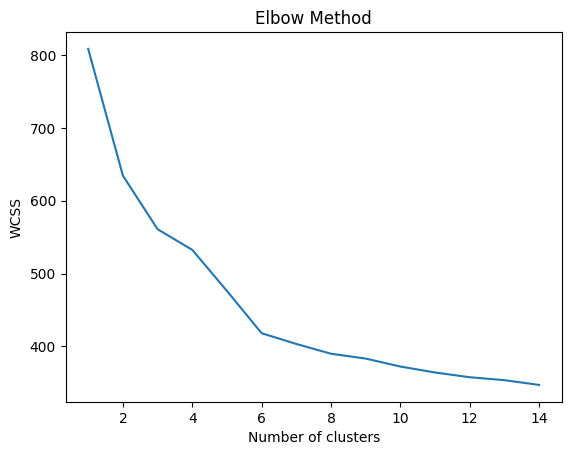

In [ ]:
def clean_and_convert_embedding(embedding):
    """
    Cleans a string representation of an embedding and converts it to a numpy array.
    If the embedding is already a numpy array, it returns it as is.
    """
    if isinstance(embedding, str):
        # Remove unwanted characters and split the string
        clean_str = embedding.replace("\n", "").replace("[", "").replace("]", "")
        str_list = clean_str.split()

        # Convert the list of strings to a list of floats.
        try:
            float_list = [float(item) for item in str_list]
            return np.array(float_list)
        except ValueError:
            return np.nan
    elif isinstance(embedding, np.ndarray):
        return embedding
    else:
        return np.nan

# Applying this function to the embeddings column
df_report["embeddings"] = df_report["embeddings"].apply(clean_and_convert_embedding)

# Filter out any rows where embeddings couldn't be converted
df_report = df_report.dropna(subset=["embeddings"])

# Converting the "embeddings" column to a numpy array
embeddings = np.stack(df_report["embeddings"].values)

# Determining the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 15):  # Trying with 1 to 15 clusters
    kmeans = KMeans(n_clusters=i, init="k-means++", max_iter=300, n_init="auto", random_state=0)
    kmeans.fit(embeddings)
    wcss.append(kmeans.inertia_)

# Plotting the results
plt.plot(range(1, 15), wcss)
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")  # Within-cluster sum of squares
plt.show()


So, from the above graph, it looks like the 6 clusters would work best for our case but for having more refined cluster, we will begin by making 7 clusters.

In [ ]:
# Initialize KMeans with 7 clusters
kmeans = KMeans(n_clusters=7, init="k-means++", max_iter=300, n_init="auto", random_state=0)

# Fit the model to the embeddings
df_report["cluster"] = kmeans.fit_predict(embeddings)

Let's see how our clustering looks like.

In [ ]:
df_report["cluster"].value_counts()

3    194
5    118
0     60
6     48
1     25
2      5
4      1
Name: cluster, dtype: int64

From the above, algorithm has classified 1 clusters with only 1 data point. This might be the case beacause this points may be outlier. Plotting this in two dimensions and visualizing the clusters can make it more clear.

Next we will visualize the clusters using `t-SNE` library.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 451 samples in 0.001s...
[t-SNE] Computed neighbors for 451 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 451 / 451
[t-SNE] Mean sigma: 0.363531
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.564278
[t-SNE] KL divergence after 300 iterations: 1.114208


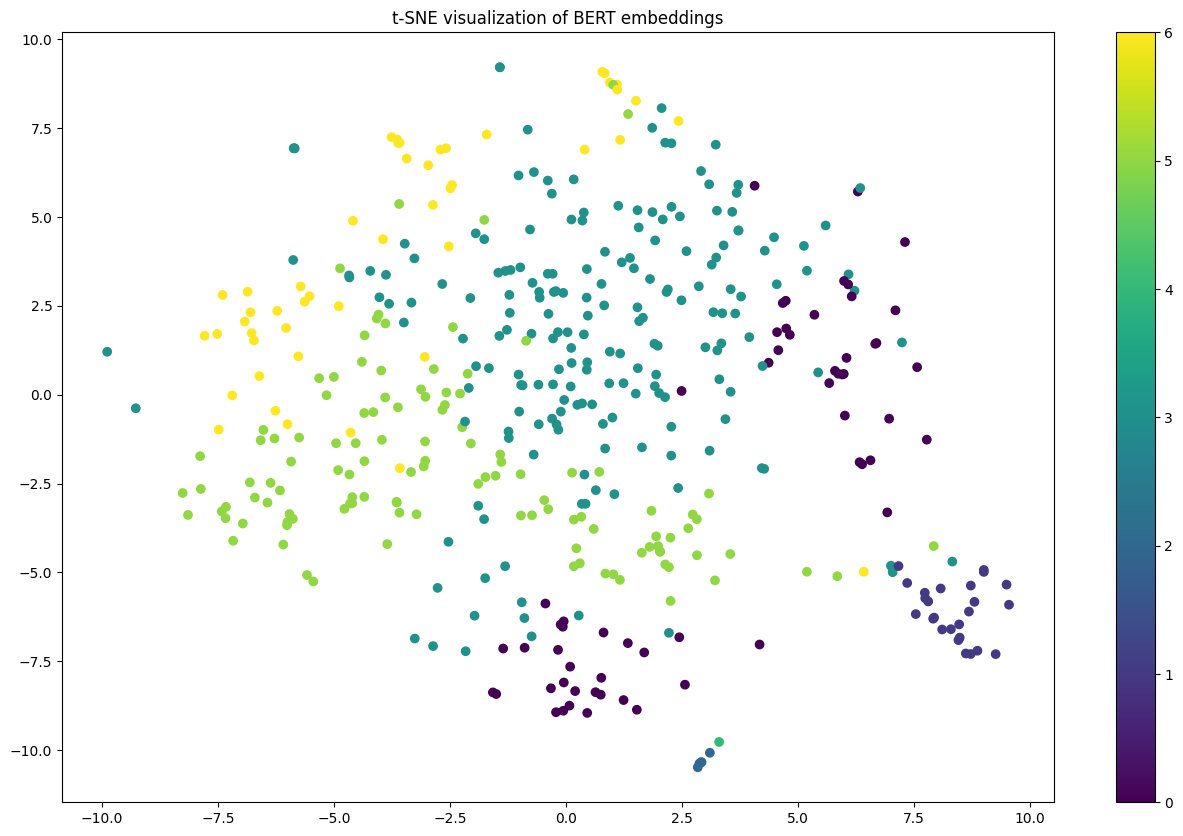

In [ ]:
clusters = df_report["cluster"].values

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embeddings)

plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=clusters, cmap="viridis")
plt.title("t-SNE visualization of BERT embeddings")
plt.colorbar(scatter)
plt.show()

So, now  our reports have been divided into 7 clusters according to their contents,

### Sentiment analysis of the report contents
Next we will try to see that what kind of tone has been used in the report. We will use rule-based sentiment-analyzer model for this.

In [ ]:
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    """
    Function to find the sentiment of the overall report
    """
    score = sia.polarity_scores(text)
    if score["compound"] >= 0.05:
        return "Positive"
    elif score["compound"] <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df_report["sentiment"] = df_report["content"].apply(analyze_sentiment)


In [ ]:
df_report.head()

,file_name,content,embeddings,cluster,sentiment
0,1_3M.pdf,Advancing\nour impact\n2023 Global Impact Repo...,"[-0.19891003, 0.25494555, 0.45294195, -0.04074...",3,Positive
1,2_AOSmith.pdf,2020 CORPORATE RESPONSIBILITY \n& SUSTAINABILI...,"[-0.22605512, 0.24607253, 0.39674193, -0.00510...",5,Positive
2,3_Abbott.pdf,GLOBAL \nSUSTAINABILITY \nREPORT 2022Sustaina...,"[-0.18347238, 0.23963231, 0.437512, -0.0442638...",3,Positive
3,4_Abbvie.pdf,ESG Action Report20222022 ESG Action Report3\n...,"[-0.20309006, 0.18193798, 0.4612571, -0.047098...",3,Positive
4,5_Accenture.pdf,360° Value Report 2022\nMeasuring value in all...,"[-0.15147045, 0.24114247, 0.5137489, -0.010319...",5,Positive


In [ ]:
df_report["sentiment"].value_counts()

Positive    451
Name: sentiment, dtype: int64

We have got overall positive sentiment for most of the reports. This is expected given that in reports, companies will show that they are doing good in terms of ESG factors.   

In [ ]:
df_report[df_report["sentiment"]=="Neutral"]

,file_name,content,embeddings,cluster,sentiment


Saving the dataframe, so that for later purposes, we can directly start from here.

In [ ]:
df_report.to_csv("after_sentiment_analysis.csv",index=True)

### Key word/Key phrase extraction
Next we will perform the keyword extraction that will extract the keywords from the texts that we got by extracting the PDFs. Let's see what kind of keywords our report has.

We will begin by cleaning process. Also we have set `max_length=4`, to get more meaningful coherent phrases, as long phrases may not be clear to interpret.

For extracting the Keyword and Key phrases, we will use RAKE alogrithm. The Rapid Automatic Keyword Extraction (RAKE) algorithm is a widely used tool in natural language processing (NLP) for identifying key phrases or keywords within a piece of text. RAKE utilizes a combination of frequency and proximity measures to identify statistically significant keywords that accurately represent the main topics or ideas conveyed in the text.

In [ ]:
def clean_and_extract_keywords(text, max_length=4):
    """
    Cleaning the text before applying RAKE algorithm
    """
    # Basic cleaning
    cleaned_text = re.sub("[^a-zA-Z0-9\s]", "", text)
    cleaned_text = re.sub("\s+", " " , cleaned_text).strip()

    rake = Rake(max_length=max_length)  # Setting a max phrase length
    rake.extract_keywords_from_text(cleaned_text)
    return rake.get_ranked_phrases_with_scores()

# Applying the function
df_report["keywords_rake"] = df_report["content"].apply(clean_and_extract_keywords)


In [ ]:
df_report.loc[0,"keywords_rake"]

[(16.0, 'rice snacks cup noodles'),
 (16.0, 'refurbish structural surfaces delaying'),
 (15.333333333333334, 'solicit employee observations attitudes'),
 (15.25, 'informed consent fpic invitations'),
 (15.0, 'label authoring registered professionals'),
 (15.0, '3500 megawatt hours powering'),
 (14.972850678733032, '650 ppm co 2'),
 (14.93010752688172, 'site replaced exterior lighting'),
 (14.916666666666666, '145000 cultural acceleration engagements'),
 (14.916666666666666, '145000 cultural acceleration engagements'),
 (14.833333333333334, '67 countriesregions13m gulf consists'),
 (14.833333333333334, '67 countriesregions13m gulf consists'),
 (14.76923076923077, 'creating fiveminute manager toolkits'),
 (14.730434782608695, 'surpass us 8918 bn'),
 (14.71764705882353, 'floods drought water scarcity'),
 (14.666666666666668, 'devices like catheters stents'),
 (14.666666666666666, 'store combustible dust chemical'),
 (14.5, 'polypropylene resin stream flowing'),
 (14.5, 'passive radiant co

In above we can interpret the result as the top two keywords, *rice snacks cup noodles* and *refurbish structural surfaces delaying*, have the highest scores, suggesting that they are the most prominent topics or ideas covered in the document. The remaining  keywords decrease in priority according to its significance in the document.

### Topic Modeling
Having extracted keywords and phrases from the individual files, we are now interested in uncovering the underlying thematic structure of the entire corpus. Since LDA operates on the corpus as a whole, not on individual documents, let's identify the main topics that emerge from our entire corpus.

In [ ]:
# Defining the stopwords, that we may exclude for Keyword extraction
STOPWORDS = set(stopwords.words("english"))

In [ ]:
# Tokenizing the documents
def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

# Applying the tokenizing function on our dataframe.
texts = [tokenize(doc) for doc in df_report["content"]]

# Creating a dictionary representation of the documents
dictionary = corpora.Dictionary(texts)

# Converting dictionary into a bag-of-words corpus
corpus = [dictionary.doc2bow(text) for text in texts]

# Applying LDA model
lda_model = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=10)

In [ ]:
# Extracting the top words for each topic
top_words_per_topic = {}
for i, topic in enumerate(lda_model.show_topics(num_topics=10, num_words=10)):
    top_words = [word for word, prop in lda_model.show_topic(i, topn=10)]
    top_words_per_topic[i] = top_words

# Print the top words for each topic
for topic, words in top_words_per_topic.items():
    print(f"Topic {topic}: {', '.join(words)}")

Topic 0: business, employees, report, esg, data, sustainability, global, risk, management, governance
Topic 1: energy, sustainability, emissions, report, climate, employees, customers, safety, business, management
Topic 2: report, fy, business, data, emissions, sustainability, people, impact, year, communities
Topic 3: water, sustainability, report, food, emissions, company, products, global, business, management
Topic 4: business, employees, keysight, management, report, company, health, also, pr, social
Topic 5: emissions, energy, management, report, sustainability, safety, employees, water, gas, data
Topic 6: report, employees, global, business, data, health, esg, management, sustainability, emissions
Topic 7: health, report, employees, sustainability, business, social, company, governance, management, care
Topic 8: esg, risk, report, business, management, financial, governance, climate, environmental, employees
Topic 9: sustainability, report, esg, emerson, energy, management, gove

In [ ]:
# Get the topics for each document
df_report["lda_topics"] = [lda_model.get_document_topics(bow) for bow in corpus]

In [ ]:
df_report.loc[0,"lda_topics"]

[(1, 0.012105579), (3, 0.012315935), (5, 0.06513977), (6, 0.88920605)]

So, we have got the topics for our document through topic modeling.

### Combining RAKE, LDA modeling & Clusters
By examining the key phrases extracted by RAKE within the context of the broader topics identified by LDA, we can better understand how specific terms and phrases relate to the overall themes in our corpus.

So, combining allows us to capture both the micro and macro aspects of our text data. Hence we can get comprehensive insight to our text data by leveraging the strengths of each method.

In [ ]:
# Function to get the dominant topic for each document
def get_dominant_topic(lda_topics):
    """
    Returns the topic number with the highest probability from a list of  tuples for a given document.
    """
    if lda_topics:
        return max(lda_topics, key=lambda item: item[1])[0]
    return None

# Applying this function to get the dominant topic
df_report["dominant_topic"] = df_report["lda_topics"].apply(get_dominant_topic)

# Initializing a dictionary to hold aggregated cluster insights
cluster_insights = {i: {"top_topics": [], "top_keywords": []} for i in range(7)}

# Aggregate insights for each cluster
for cluster_num in range(7): # as we have 7 clusters
    # Filter the DataFrame for the current cluster
    cluster_df = df_report[df_report["cluster"] == cluster_num]

    # Aggregate top topics
    top_topics = cluster_df["dominant_topic"].value_counts().head(3).index.tolist()
    cluster_insights[cluster_num]["top_topics"] = top_topics

    # Aggregate top RAKE keywords
    all_keywords = [keyword for row in cluster_df["keywords_rake"] for keyword, score in row]
    top_keywords = pd.Series(all_keywords).value_counts().head(10).index.tolist()
    cluster_insights[cluster_num]["top_keywords"] = top_keywords

# Print the aggregated insights for each cluster
for cluster_num, insights in cluster_insights.items():
    print(f"Cluster {cluster_num}:")

    # Convert each list of top words into a string
    top_topics_str = [', '.join(top_words_per_topic[topic]) for topic in insights["top_topics"]]
    print(f"Top Topics: {'; '.join(top_topics_str)}")

    # Ensure that all keywords are strings
    top_keywords_str = [str(keyword) for keyword in insights["top_keywords"]]
    print(f"Top Keywords: {', '.join(top_keywords_str)}")
    print()


Cluster 0:
Top Topics: report, employees, global, business, data, health, esg, management, sustainability, emissions; esg, risk, report, business, management, financial, governance, climate, environmental, employees; business, employees, report, esg, data, sustainability, global, risk, management, governance
Top Keywords: 1.0, 2.0, 4.0, 1.5, 1.6666666666666667, 2.5, 1.3333333333333333, 4.5, 5.0, 2.3333333333333335

Cluster 1:
Top Topics: emissions, energy, management, report, sustainability, safety, employees, water, gas, data; energy, sustainability, emissions, report, climate, employees, customers, safety, business, management; health, report, employees, sustainability, business, social, company, governance, management, care
Top Keywords: 1.0, 2.0, 4.0, 1.5, 2.5, 1.6666666666666667, 1.3333333333333333, 4.5, 5.0, 2.3333333333333335

Cluster 2:
Top Topics: business, employees, keysight, management, report, company, health, also, pr, social; report, fy, business, data, emissions, sustai

The above output indicates the primary themes and specific phrases characterizing each cluster, summarizing the textual data's key focus areas.

Next we will give the name to the clusters based on the top topics discussed inside each clusters. In the hash tag it is also mentioned that why this name was given to the clusters.

In [ ]:
# Creating a dictionary for cluster name mapping
cluster_name_mapping = {
    0: "Corporate Responsibility and Environmental Management", # This cluster seems to focus on corporate governance, employee involvement, environmental issues, and energy management in business settings.
    1: "Business Risk and Data Analysis", # This cluster emphasizes business risk, data handling, and possibly travel-related aspects, indicating a focus on analytics, risk management, and possibly mobile workforce considerations.
    2: "Comprehensive ESG and Global Sustainability",  # The emphasis here is on Environmental, Social, and Governance (ESG) factors, global business practices, sustainability, and health, indicating a broad approach to sustainable and responsible business practices.
    3: "Environmental Sustainability and Safety in Energy", # This cluster combines elements of environmental sustainability, energy management, and safety, suggesting a focus on environmentally responsible energy practices and safety measures.
    4: "Global Health and Corporate Social Responsibility", # The focus is predominantly on health, global business impacts, and corporate social responsibility, particularly in relation to food and employee welfare.
    5: "Strategic Risk Management in Business", # This cluster appears to deal with strategic aspects of business, focusing on risk, data analysis, and sustainability, indicating a concentration on managing business risks and strategic planning.
    6: "Global Sustainability and Governance" # This cluster brings together themes of global sustainability, employee engagement, and governance, emphasizing a comprehensive approach to sustainable practices and corporate governance.
}

# Mapping the cluster names to the DataFrame
df_report["cluster_name"] = df_report["cluster"].map(cluster_name_mapping)

In [ ]:
df_report.to_csv("after_cluster_naming.csv",index=False)

Getting the combined insights from the result we have.

In [ ]:
df_report["combined_insights"] = df_report.apply(
    lambda row: {"rake_keywords": row["keywords_rake"], "lda_topics": row["lda_topics"]}, axis=1)

### Adding sectors
We intend to add the respective sectors to our data frame to identify which company belongs to which sector. However, a challenge arises from the fact that the reports were not saved with the original company names but rather with initials or acronyms. This prevents us from directly extracting data from the table using SQL or programming queries and linking sectors to their respective companies.

 Hence, we need to manually assign companies to their respective sectors.

In [ ]:
Industrials = ["23_Ameren","49_Adp","65_Boeing","72_Broadridge","73_BuilderFirst","82_Carrier","94_Chr","104_Cintas","121_Copart","Industrials","129_Cummins","132_JohnDeere",
               "133_DeltaAirlines","149_Eaton","Emerson Electric","168_Expeditors","173_FastEnal","193_GeneRac","194_GeneralDynamics","195_Ge","212_Honeywell",
               "215_Howmet","217_Hubbell","218_Huamana","219_Hutington","220_Hii","224_Itw","227_Ingersoll","238_Jbht","243_JohnsonControls","255_L3Harris","260_Leidos",
               "265_LockheedMartin","275_Masco","308_Nordson","309_Norfolk","311_Northrop","318_OldDpminion","323_Otis","325_Pca","328_Parker","329_Paychex","330_Paycom",
               "332_Pentair","351_Quanta","356_Rtx","363_RobertHalf","364_RockewllAutomation","365_RollinsInc","379_Southwest","399_Textron","403_Trane","404_Transdigm",
               "410_Uber","412_UnitedAirlines","413_UnitedRentals","417_Veralto","418_Verisk","427_Wabtec","432_Waste_Management","446_Xylem_Inc"]
Healh_Care = ["3_Abbott","4_Abbvie","10_Agilent","32_Amgen","57_Baxter","58_Bd","61_BioRad","62_Biotechne","63_Biogen","69_Boston_Scientific","70_BristolMyer",
              "79_CardinalHealth","83_Catalent","84_Catterpillar","89_Cencora","90_Centene","95_CharlesRiver","102_Cigna","120_CooperCompanies","130_Cvs","131_Danaher",
              "134_Dentsply","136_Dexcom","153_Edward","155_ElevanceHealth","156_EliLilly","191_GeHealthcare","198_Gilead","205_Hsic","210_Hologic","222_Idex","225_Illumina",
              "226_Incyte","256_LabCorp","279_McKesson","280_Medtronic","281_MerkCo","284_Mettler","290_Moderna","292_Molina","334_Pfizer","353_Quest","359_Regeneron","361_ResMed",
              "362_Revvity","383_Styker","395_Teleflex","400_ThermoFisher","414_UnitedHealth","420_Vertex","422_Viartis","433_Water_Corp","437_West_Pharmaceutical_Company",
              "449_Zimmer","451_Zoetis"]
Information_Technology = ["5_Accenture","6_Adobe","7_AMD","12_Akami","33_Amphenol","34_AnalogDevices","35_Ansys","38_Apple","39_AppliedMaterials",
                          "43_Arista","48_Autodesk","71_Broadcom","74_Cadence","87_CDW","105_Cisco","122_Corning","158_Enphase","178_FirstSolar","184_Fortinet",
                          "190_Gartner","192_GenDigital","208_Hpe","216_Hp","221_Ibm","229_Intel","233_Intuit","239_Jabil","245_Juniper","249_KeySight","252_Kla","	Lam Research",
                          "286_Microchip","287_Micron","288_Microsoft","295_Mps","299_Motorola","301_NetApp","315_Nvidia","316_Nxp","320_Onsemi",
                          "322_Oracle","326_PaloAltoNetwork","347_Ptc","350_Qorvo","352_Qualcom","366_RopperTech","371_Seagate","373_ServiceNow","376_SkyWork",
                          "385_Synopsys","393_TeConnectivity","394_Teledyne","396_Teradyne","398_TexasInstrument","406_Trimble","438_Western_digital","448_ZebraTech"]
Utilities = ["8_AES","17_Alliant","23_Ameren","25_AEP","29_AmericanWater","91_CenterPointEnergy","109_CMSEnergy","117_ConEdison","119_ConstellationENergey",
             "141_DominionEnergy","145_Dte","146_DukeEnergy","152_Edison","Entergy","166_exelon","305_NextEraEnergy","307_NiSource","337_PinnacleWest","341_Ppl","346_Pseg",
             "372_SemparaEnergy","378_Southern","434_Wec_Energy_Group","445_Xcel_Energy"]
Financials = ["9_Aflac","19_AllStates","26_AME","30_AmeripriseFinal","36_Aon","40_Aptiv","44_Ajg","45_Assurant","54_Bank_Of_America","55_Bny",
              "64_Blackstone","78_Capital_One","85_Cboe","103_Cinf","106_Citi","107_Citizens","108_CME","139_DiscoverFinancial","172_FactSet","177_FifthThirdBank","180_Fiserv",
              "181_FleetCore","187_FranklinTempleton","199_GlobalPayments","200_GlobalLife","201_GoldmanSachs","203_HartFord","234_Invesco","240_JackHenry","244_JPMorgan",
              "248_KeyCorp","268_MnT","271_MarketAxess","273_MarshMeclanan","276_MasterCard","283_MetLife","297_Moody","298_MorganStanely","300_Nasdaq","310_NorthenTrust",
              "339_Pnc","343_Progressive","345_Prudential","355_RaymondJames","360_Regions","368_SnPGlobal","331_Paypal","381_StateStreet","384_Synchrony","388_TRowe","405_Travelers",
              "407_Truist","409_UsBank","424_Visa","435_Wells_Fargo","443_Wtw","450_Zion"]
Materials = ["13_Albemarl","22_Amcor","50_AveryDennison","53_Ball","88_Cleanese","93_CfIndustries","143_DowInc","147_Dupont","148_EastMan","151_Ecolab","182_Fmc",
             "230_Iff","231_IntPaper","262_Linde","267_Lyb","274_MartinMarieta","303_Newmont","314_Nucor","374_SerwinWilliams","382_SteelDynamics","425_Vulcan","439_Westrock"]
Consumer_Discretionary = ["21_Amazon","40_Aptiv","49_Autozone","56_BathnBody","60_BestBuy","66_BookingHoldings","67_BorgWarner","75_Caesars","80_CarMax",
                          "81_Carnival","99_Chipotle","142_Dominos","144_Drhorton","150_eBay","167_ExpediaGroup","183_Ford","197_Gpc","Hasbro","209_Hilton","211_HomeDepot",
                          "261_Lennar","264_Lkq","266_Lululemon","272_Mariott","285_Mgm","291_Mohawk","306_Nike","312_Nclh","317_Oxy","340_PoolCorp",
                          "349_Plute","354_RalphLauren","367_RoyalCarribean","380_Starbucks","390_Tapestry","397_Tesla","401_Tjx","402_TractorSupply","411_UltaBeauty",
                          "421_VfCorp","441_Whirlpool","444_Wynn_Resorts","447_YumBrands"]
Real_Estate = ["14_ARE","28_AmericanTower","68_BostonProperties","76_Camden","86_CBRE_Group","124_CostarGroup","127_CrownCastle","138_DigitalRealty","160_EquityResidntial",
               "161_EssexProperty","169_ExtraSpace","204_HealthPeak","214_HostHotels","235_InvitationHome","237_IronMountain","289_MidAmericaApt","344_Prologis","348_PublicStorage",
               "357_RealtyIncome","358_RegencyCenter","369_Sba","375_Simon","411_Udr","416_Ventas","423_Vici","426_Berkley","436_Welltower","440_Wy"]
Consumer_Staples = ["20_Altria","42_Adm","77_Campbell","101_Church&Dwight","110_CocaCola","112_Colgate","115_Congora","118_Constellation","125_Costco","140_DollarGeneral",
                    "162_EsteeLauder","196_GeneralMills","206_Herashey","213_HormalFood","247_Kdp","250_KimberlyClark","253_KraftHeinz","254_Kroger","258_LambWeston",
                    "278_McCormick","293_Molson","294_Mondelez","296_MonsterBev","333_Pepsico","335_Pmi","342_Png","377_Smucker","386_Sysco","392_Target","408_TysonFood",
                    "428_Wallgreen","429_Wallmart"]
Energy = ["37_Apa","52_BKR","98_Chevron","116_ConocoPhilips","123_Corteva","126_Coterra","135_Devon","137_DiamondBackEnergy","159_EogResources","165_Eversource",
          "202_Halliburton","207_Hess","251_Kmi","269_MarathonOil","270_MarathonPetroleum","321_Oneok","336_Phillips","338_PioneerNaturalResources","370_SchlumBerger","391_Targa",
          "415_Valero_Energy","442_William",]
Communication_Services = ["19_Alphabet_Google","46_At&t","47_Atmos","97_CharterCommunication","113_Comcast","154_Ea","186_FoxCorp","232_Ipg","277_MatchGroup",
                          "282_Meta","302_Netflix","304_NewsCorp","319_Omnicom","327_Paramount","387_TMobile","389_T2","419_Verizon","430_Walt_Disney","431_Warner_Bros",
                          ]


Now adding the word ".pdf" in the end of them for a better matching

In [ ]:
# Adding ".pdf" to each element in the list
Industrials = [name + ".pdf" for name in Industrials]
Healh_Care = [name + ".pdf" for name in Healh_Care]
Information_Technology = [name + ".pdf" for name in Information_Technology]
Utilities = [name + ".pdf" for name in Utilities]
Financials = [name + ".pdf" for name in Financials]
Materials = [name + ".pdf" for name in Materials]
Consumer_Discretionary = [name + ".pdf" for name in Consumer_Discretionary]
Real_Estate = [name + ".pdf" for name in Real_Estate]
Consumer_Staples = [name + ".pdf" for name in Consumer_Staples]
Energy = [name + ".pdf" for name in Energy]
Communication_Services = [name + ".pdf" for name in Communication_Services]

In [ ]:
Industrials[:5]

['23_Ameren.pdf',
 '49_Adp.pdf',
 '65_Boeing.pdf',
 '72_Broadridge.pdf',
 '73_BuilderFirst.pdf']

Next we will create a mapping of company names to sectors.

In [ ]:
# Creating a mapping of names to sectors
name_to_sector = {}
for sector, names in {"Industrials":Industrials,"Health Care":Healh_Care,"Information Technology":Information_Technology,"Utilities": Utilities,
                      "Financials": Financials, "Materials": Materials,"Consumer Discretionary":Consumer_Discretionary,"Real Estate":Real_Estate,
                      "Consumer Staples":Consumer_Staples,"Energy":Energy,"Communication Services":Communication_Services}.items():
  for name in names:
    name_to_sector[name] = sector

# Function to map filename to sector
def map_name_to_sector(filename):
    return name_to_sector.get(filename, 'Unknown')  # Default to 'Unknown' if no match

In [ ]:
# Apply the function to create the "Sector" column
df_report["Sector"] = df_report["file_name"].apply(map_name_to_sector)

In [ ]:
df_report["Sector"].value_counts()

Industrials               58
Information Technology    56
Health Care               55
Financials                55
Consumer Discretionary    42
Unknown                   40
Consumer Staples          32
Real Estate               28
Utilities                 23
Energy                    22
Materials                 21
Communication Services    19
Name: Sector, dtype: int64

From above, there are few Unknown sectors, but we have their respective sectors available. So, we will manually add the name of those sectors which are missing.

In [ ]:
# Let's save the dataframe
df_report.to_csv("after_sector_adding.csv",index=False)

In [ ]:
df_report.loc[0,"Sector"] = "Industrials"
df_report.loc[1,"Sector"] = "Industrials"
df_report.loc[10,"Sector"] = "Consumer Discretionary"
df_report.loc[12,"Sector"] = "Materials"
df_report.loc[14,"Sector"] = "Industrials"
df_report.loc[16,"Sector"] = "Financials"
df_report.loc[24,"Sector"] = "Financials"
df_report.loc[28,"Sector"] = "Industrials"
df_report.loc[38,"Sector"] = "Financials"
df_report.loc[49,"Sector"] = "Industrials"
df_report.loc[57,"Sector"] = "Financials"
df_report.loc[90,"Sector"] = "Industrials"
df_report.loc[94,"Sector"] = "Financials"
df_report.loc[98,"Sector"] = "Financials"
df_report.loc[109,"Sector"] = "Information Technology"
df_report.loc[111,"Sector"] = "Communication Services"
df_report.loc[112,"Sector"] = "Financials"
df_report.loc[126,"Sector"] = "Industrials"
df_report.loc[155,"Sector"] = "Industrials"
df_report.loc[161,"Sector"] = "Financials"
df_report.loc[162,"Sector"] = "Utilities"
df_report.loc[168,"Sector"] = "Energy"
df_report.loc[169,"Sector"] = "Information Technology"
df_report.loc[172,"Sector"] = "Real Estate"
df_report.loc[173,"Sector"] = "Industrials"
df_report.loc[174,"Sector"] = "Financials"
df_report.loc[177,"Sector"] = "Utilities"
df_report.loc[183,"Sector"] = "Industrials"
df_report.loc[186,"Sector"] = "Materials"
df_report.loc[187,"Sector"] = "Consumer Discretionary"
df_report.loc[221,"Sector"] = "Health Care"
df_report.loc[226,"Sector"] = "Health Care"
df_report.loc[234,"Sector"] = "Health Care"
df_report.loc[239,"Sector"] = "Industrials"
df_report.loc[240,"Sector"] = "Health Care"
df_report.loc[244,"Sector"] = "Consumer Staples"
df_report.loc[255,"Sector"] = "Information Technology"
df_report.loc[257,"Sector"] = "Consumer Discretionary"
df_report.loc[261,"Sector"] = "Communication Services"
df_report.loc[309,"Sector"] = "Utilities"
df_report.loc[320,"Sector"] = "Industrials"
df_report.loc[449,"Sector"] = "Industrials"

In [ ]:
# Checking for "Unknown" value
df_report["Sector"].value_counts()

Industrials               69
Financials                60
Information Technology    56
Health Care               55
Consumer Discretionary    43
Consumer Staples          30
Real Estate               26
Utilities                 24
Unknown                   24
Energy                    23
Materials                 22
Communication Services    20
Name: Sector, dtype: int64

In [ ]:
# Saving our dataframe.
df_report.to_csv("after_final_sectors.csv",index=False)

### Frequency and presence of keywords sector wise
Next we will show to which sectors the key word might belongs to, and their overall presence. Since we are dealing with user query we need to preprocess the query like extracting the noun and pronoun from the document.  

This is the program strucutre of the code written in the block below:
1. We need to do the pre-processing of text. In this step we convert all text to lowercase and remove any non-alphanumeric characters.  
2. Next we process the input query using spaCy to extract noun phrases and nouns, providing a list of keywords.
3. Then we determine whether each keyword is present in a given document using regular expressions to match whole words.
4. After that for a list of documents,we check the presence of each keyword using the previously defined keyword check function.
5. Next we calculate the frequency of each keyword across all documents by counting occurrences using regular expressions.
6. In the end, we sort the sectors based on the count of keyword presence

In [ ]:
def preprocess_text(text):
    """ Basic text preprocessing """
    # Check if the input is a string
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r"[^a-z0-9\s]", "", text)
        return text
    else:
        # Return an empty string or a placeholder if it's not a string
        return ""

def extract_keywords_spacy(query):
    """ Extracts key noun phrases and nouns using spaCy """
    doc = nlp(query)
    keywords = [chunk.text for chunk in doc.noun_chunks] + [token.text for token in doc if token.pos_ in ["NOUN", "PROPN"]]
    return keywords

def keyword_in_document(keyword, document):
    """ Check if a whole keyword is present in a document """
    pattern = r'\b' + re.escape(keyword) + r'\b'
    return re.search(pattern, document) is not None

def search_keywords_in_documents(keywords, documents):
    """ Search for the occurrence of keywords in a list of documents """
    return [any(keyword_in_document(keyword, doc) for keyword in keywords) for doc in documents]

def keyword_frequency_in_documents(keyword, documents):
    """ Count the frequency of a keyword in a list of documents """
    pattern = r'\b' + re.escape(keyword) + r'\b'
    return sum(len(re.findall(pattern, doc)) for doc in documents)

def analyze_query_in_sectors(query, df_report):
    """ Analyze a query in the context of sectors """
    # Extract keywords from the query
    keywords = extract_keywords_spacy(query)

    # Preprocess documents and search for keywords
    df_report["content_processed"] = df_report["content"].apply(preprocess_text)
    df_report["keyword_present"] = search_keywords_in_documents(keywords, df_report["content_processed"])

    # Aggregate counts by sector where keyword is present
    sector_keyword_presence = df_report[df_report["keyword_present"]].groupby("Sector").size()

    # Calculate keyword frequency in each sector
    sector_keyword_freq = {sector: sum(keyword_frequency_in_documents(keyword, df_report[df_report["Sector"] == sector]["content_processed"]) for keyword in keywords)
                           for sector in df_report["Sector"].unique()}

    # Sort sectors by keyword presence count
    sorted_sectors = sector_keyword_presence.sort_values(ascending=False)

    return sorted_sectors, sector_keyword_freq

In [ ]:
# Test the function with a query
query = "new doctors appointed"
sorted_sectors, sector_keyword_freq = analyze_query_in_sectors(query, df_report)

# Display the results
print("Sectors most related to the query keywords:")
print(sorted_sectors)
print("\nKeyword frequency in each sector:")
for sector, freq in sector_keyword_freq.items():
    print(f"{sector}: {freq}")

Sectors most related to the query keywords:
Sector
Health Care               29
Consumer Discretionary     8
Financials                 7
Information Technology     7
Real Estate                5
Unknown                    4
Communication Services     3
Consumer Staples           3
Industrials                3
Energy                     1
Materials                  1
dtype: int64

Keyword frequency in each sector:
Industrials: 5
Health Care: 63
Information Technology: 12
Utilities: 0
Financials: 10
Consumer Discretionary: 10
Materials: 1
Real Estate: 6
Unknown: 7
Communication Services: 3
Consumer Staples: 3
Energy: 1


### Keyword result cluster wise
In the previous block of code we tried to map the query to the sectors. Next we see that query could be mapped to clusters as well.

This is the overall program flow of below block of code:
1. A helper function extracts keywords from documents, focusing on nouns, proper nouns, and adjectives.
2. The main function starts by extracting keywords from a given query using the helper function.
3. It then identifies unique clusters in a dataset.

4. For each cluster, the function extracts documents associated with that cluster and uses the helper function to find the most common keywords in these documents.

5. The function compares the keywords from the query with the common keywords of each cluster, calculating a match score based on the overlap.

6. Clusters are then sorted by their match score, indicating how relevant they are to the query.

7. The function concludes by returning these sorted clusters, from most to least relevant to the query.

8. Finally, the function is called with an example query, and it prints the relevant clusters and their match scores, or a message if no relevant clusters are found.








In [ ]:
def extract_keywords_from_documents(documents):
    """
    Helper function. Extract and accumulate all nouns, proper nouns, and adjectives as lowercase keywords.
    """
    all_keywords = []
    for doc in documents:
        all_keywords.extend([token.text.lower() for token in nlp(doc) if token.pos_ in ["NOUN", "PROPN", "ADJ"]])
    return all_keywords

def map_query_to_clusters(query, df_report, cluster_column="cluster", content_column="content"):
    """
    Function maps a query to clusters within a dataframe by extracting keywords from the query,
    identifying the most common keywords in each cluster,
    and then ranking the clusters based on the overlap of their keywords with the query's keywords.
    """
    # Extract keywords from the query
    query_keywords = set(extract_keywords_from_documents([query]))

    # Get unique clusters
    unique_clusters = df_report[cluster_column].unique()

    # Initialize the dictionary to store cluster keywords
    cluster_keywords = {}

    # Iterate over each cluster and extract keywords
    for cluster in unique_clusters:
        cluster_docs = df_report[df_report[cluster_column] == cluster][content_column]
        keywords = extract_keywords_from_documents(cluster_docs)
        most_common_keywords = [word for word, count in Counter(keywords).most_common(10)]
        cluster_keywords[cluster] = most_common_keywords

    # Match query keywords with cluster keywords
    relevant_clusters = {}
    for cluster, keywords in cluster_keywords.items():
        match_score = len(query_keywords.intersection(set(keywords)))
        if match_score > 0:
            relevant_clusters[cluster] = match_score

    # Return sorted relevant clusters based on match score
    return sorted(relevant_clusters.items(), key=lambda x: x[1], reverse=True)

# Function call with example query
query = "We have successfully reduced the carbon footprint."
relevant_cluster_mapping = map_query_to_clusters(query, df_report)

# Print the relevant clusters and their match scores
if relevant_cluster_mapping:
    for cluster, score in relevant_cluster_mapping:
        print(f"Cluster {cluster} ({df_report['cluster_name'].loc[df_report['cluster'] == cluster].iloc[0]}): Match Score = {score}")
else:
    print("No relevant clusters found for the query.")


No relevant clusters found for the query.


### Bringing leadership messages to the context
Next we will connect the Leader's message to our work. First we need to connect to Google drive and bring the messages to the environment.

In [ ]:
leadership_messgaes_path = "/content/gdrive/MyDrive/Leadership_Messages"

Next we extract the text and data from these PDFs files of Leadership messages as we did it for the full sustainability report and store these text in a separate dataframe that we will use later to combine with original report.

In [ ]:
data = []
# We will check that if file name ends with pdf, we extract the data from it
extract_path = "/content/extracted_messages"

# If folder doesn't exist, create a folder. Later we'll save extracted file to this folder.
if not os.path.exists(extract_path):
  os.makedirs(extract_path)

for file_name in os.listdir(leadership_messgaes_path):
  if file_name.endswith(".pdf"):
    file_path = os.path.join(leadership_messgaes_path,file_name)

    # Opening the PDF files
    with open(file_path,"rb") as file:
      reader =PdfReader(file)
      text = ""

      # Iterate over each page and extract text
      for page in reader.pages:
        text += page.extract_text()

      # Append the data file name and text
      data.append({"file_name":file_name,"content_leadership":text})

# Create a dataframe of all the leadership messages
df_leadership = pd.DataFrame(data)

In [ ]:
df_leadership.head()

,file_name,content_leadership
0,63_Biogen.pdf,\nOVERVIEW 4\nBIOGEN 2022 ESG REPORT ACCES...
1,64_Blackstone.pdf,∙ 4 \n \n \n \n \n \n \n \n \n \...
2,65_Boeing.pdf,President and CEO Message\nSustainability\nAlo...
3,66_BookingHoldings.pdf,"\n \n \n \n In 2022, the enduring resilience..."
4,67_BorgWarner.pdf,Executive Summary Environmental Stewardship So...


Now we will check for the file names of these. This file name should be common for both.

In [ ]:
df_leadership[df_leadership["file_name"]=="52_BKR.pdf"]

,file_name,content_leadership
369,52_BKR.pdf,Baker Hughes 5\nPlanet 58\nFigure 5-1: Tot...


In [ ]:
df_report[df_report["file_name"]=="52_BKR.pdf"]

,file_name,content,embeddings,cluster,sentiment,keywords_rake,lda_topics,dominant_topic,cluster_name,combined_insights,Sector,content_processed,keyword_present
51,52_BKR.pdf,Corporate Sustainability Report 2022\nPeople F...,"[-0.24052702, 0.22965626, 0.4266511, -0.059589...",3.0,Positive,"[(16.0, 5035156353 8654743702 8071 visit), (16...","[(0, 0.51806253), (5, 0.46112463), (6, 0.01360...",0.0,Environmental Sustainability and Safety in Energy,"{'rake_keywords': [(16.0, '5035156353 86547437...",Energy,corporate sustainability report 2022\npeople f...,False


Since from the above we saw that file names are same for both of these dataframe, so we will merge both the dataframe by follwoing the concept of LEFT JOIN of SQL.

In [ ]:
df_merged =  pd.merge(df_report,df_leadership,on="file_name",how="left")

In [ ]:
df_merged.head(3)

,file_name,content,embeddings,cluster,sentiment,keywords_rake,lda_topics,dominant_topic,cluster_name,combined_insights,Sector,content_processed,keyword_present,content_leadership
0,1_3M.pdf,Advancing\nour impact\n2023 Global Impact Repo...,"[-0.19891003, 0.25494555, 0.45294195, -0.04074...",3.0,Positive,"[(16.0, rice snacks cup noodles), (16.0, refur...","[(1, 0.012105579), (3, 0.012315935), (5, 0.065...",6.0,Environmental Sustainability and Safety in Energy,"{'rake_keywords': [(16.0, 'rice snacks cup noo...",Industrials,advancing\nour impact\n2023 global impact repo...,True,A message from \nGayle Schueller\nI had the g...
1,2_AOSmith.pdf,2020 CORPORATE RESPONSIBILITY \n& SUSTAINABILI...,"[-0.22605512, 0.24607253, 0.39674193, -0.00510...",5.0,Positive,"[(15.5, fulltime asme inspectors onsite), (15....","[(1, 0.14729802), (3, 0.03998608), (5, 0.14737...",6.0,Strategic Risk Management in Business,"{'rake_keywords': [(15.5, 'fulltime asme inspe...",Industrials,2020 corporate responsibility \n sustainabilit...,False,A Letter from Our \nChairman and CEO\nWater is...
2,3_Abbott.pdf,GLOBAL \nSUSTAINABILITY \nREPORT 2022Sustaina...,"[-0.18347238, 0.23963231, 0.437512, -0.0442638...",3.0,Positive,"[(16.0, wireless implants wearable sensors), (...","[(3, 0.017338207), (6, 0.9788631)]",6.0,Environmental Sustainability and Safety in Energy,"{'rake_keywords': [(16.0, 'wireless implants w...",Health Care,global \nsustainability \nreport 2022sustaina...,True,"This is Abbott’s 135th anniversary year, which..."


In [ ]:
df_merged.isna().sum()

file_name              1
content                1
embeddings             1
cluster                1
sentiment              1
keywords_rake          1
lda_topics             1
dominant_topic         1
cluster_name           1
combined_insights      1
Sector                 0
content_processed      0
keyword_present        0
content_leadership    42
dtype: int64

Since for not all companies leadership messages are available, that's why we are seeing the null values in  `content_leadership` column.

### Result after combining leadership messages with reports
Now since we have combined the both of the files we can extract data from both the files together.

Here is the program flow of the below code block:

1. First we will define a function to preprocess and clean text by removing special characters, converting to lowercase, and handling missing values.

2. Then we will extract keywords from a query using natural language processing techniques.

3. Next we count the frequency of these keywords across a set of documents.

4. After that we define a  main function to search for these keyword frequencies in a given dataframe. And in that main function part follwoing task will be done :

  1.   We extract keywords from the input query
  2.   Next we preprocess the content in two different columns of the dataframe.
  3.   We initialize a results dictionary to store keyword frequencies in different sectors and leadership messages.
  4. Next we calculate the frequency of keywords in each sector of the dataframe and store the results.
  5. After that we calculate the frequency of keywords in the leadership messages, filtering out empty messages, and store the results.
  6. In the end, we display the frequencies of keywords for each sector and for leadership messages, along with the total occurrences.

In [ ]:
# Function to preprocess and clean text
def clean_text(text):
    """
    Text preprocessing. Removes newline characters, non-alphanumeric characters, and converts the text to lowercase
    """
    # Handle missing values
    if pd.isna(text):
        return ""
    text = re.sub(r"[\r\n]", " ", text)  # Replace newline characters
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)  # Remove non-alphanumeric characters
    text = text.lower()  # Convert to lower case
    return text

# Function to extract keywords using spaCy
def extract_keywords_spacy(query):
    """
    Extract the keywords from the phrase
    """
    doc = nlp(query)
    return [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and token.pos_ in ["NOUN", "PROPN", "ADJ"]]

# Function to count the frequency of keywords in documents
def keyword_frequency_across_documents(keywords, documents):
    return sum(doc.count(keyword) for doc in documents for keyword in keywords)

# Function to search query in reports and leadership messages
def search_and_display_keyword_data(query, df):
    """
    This function searches for frequencies of keywords from a query within different sectors and
    leadership messages in a dataframe, then displays these frequencies.
    """
    # Extract keywords from the query
    keywords = extract_keywords_spacy(query)

    # Preprocess the report and leadership contents
    df["cleaned_content"] = df["content"].apply(clean_text)
    df["cleaned_content_leadership"] = df["content_leadership"].apply(clean_text)

    # Initialize results dictionary
    results = {"sectors": {}, "leadership_messages": 0}

    # Calculating frequency in sectors
    for sector in df["Sector"].unique():
        sector_docs = df[df["Sector"] == sector]["cleaned_content"]
        sector_frequency = keyword_frequency_across_documents(keywords, sector_docs)
        results["sectors"][sector] = sector_frequency

    # Calculating frequency in leadership messages
    leadership_docs = df["cleaned_content_leadership"]
    # Filtering out empty leadership messages
    leadership_docs = leadership_docs[leadership_docs != ""]
    leadership_frequency = keyword_frequency_across_documents(keywords, leadership_docs)
    results["leadership_messages"] = leadership_frequency

    # Displaying the results
    print(f"Keyword frequencies for query '{query}':")
    print("Sector Frequencies:")
    for sector, frequency in results["sectors"].items():
        print(f"{sector}: {frequency}")
    print(f"Total occurrences in leadership messages: {results['leadership_messages']}")


In [ ]:
# Defining a random custom query
query = "We have focused on green energy last year"
# Executing the function
search_and_display_keyword_data(query, df_merged)

Keyword frequencies for query 'We have focused on green energy last year':
Sector Frequencies:
Industrials: 11775
Health Care: 6801
Information Technology: 10505
Utilities: 9747
Financials: 9885
Consumer Discretionary: 6692
Materials: 4899
Real Estate: 5555
Unknown: 2822
Communication Services: 3027
Consumer Staples: 4776
Energy: 6354
Total occurrences in leadership messages: 2627


### Putting all the data into SQL database
Next what we will do that we put all the data into a database, because this could be later used for adding more companies data or may be deleting the data of comapnies if in the next S&P indexing, they don't make it to the list. As companies publish their ESG report annually and S&P updates its list sometimes even 4 times in a year.

So, this is to be done for keeping future perspective in the mind. For constructing the databae we will use `sqlite` library.

In [ ]:
# Visualizing our dataframe.
df_merged.head(2)

,file_name,content,embeddings,cluster,sentiment,keywords_rake,lda_topics,dominant_topic,cluster_name,combined_insights,Sector,content_processed,keyword_present,content_leadership,cleaned_content,cleaned_content_leadership
0,1_3M.pdf,Advancing\nour impact\n2023 Global Impact Repo...,"[-0.19891003, 0.25494555, 0.45294195, -0.04074...",3.0,Positive,"[(16.0, rice snacks cup noodles), (16.0, refur...","[(1, 0.012105579), (3, 0.012315935), (5, 0.065...",6.0,Environmental Sustainability and Safety in Energy,"{'rake_keywords': [(16.0, 'rice snacks cup noo...",Industrials,advancing\nour impact\n2023 global impact repo...,True,A message from \nGayle Schueller\nI had the g...,advancing our impact 2023 global impact report...,a message from gayle schueller i had the goo...
1,2_AOSmith.pdf,2020 CORPORATE RESPONSIBILITY \n& SUSTAINABILI...,"[-0.22605512, 0.24607253, 0.39674193, -0.00510...",5.0,Positive,"[(15.5, fulltime asme inspectors onsite), (15....","[(1, 0.14729802), (3, 0.03998608), (5, 0.14737...",6.0,Strategic Risk Management in Business,"{'rake_keywords': [(15.5, 'fulltime asme inspe...",Industrials,2020 corporate responsibility \n sustainabilit...,False,A Letter from Our \nChairman and CEO\nWater is...,2020 corporate responsibility sustainabilit...,a letter from our chairman and ceo water is o...


In [ ]:
# For saving the data
# df_merged.to_csv("final_analysis.csv",index=False)

 Before saving the datafame result as a database we need to process some column as a `json` type because they do not represent any datatype in sql format and sql may throw error to us.

 The column which needs conversion in our dataframe for storing in databases are: `["embeddings", "keywords_rake", "lda_topics", "combined_insights"]`

In [ ]:
class CustomJSONEncoder(json.JSONEncoder):
    """ Custom JSON encoder to handle numpy data types """
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                              np.int16, np.int32, np.int64, np.uint8,
                              np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.bool_)):
            return bool(obj)
        elif pd.isna(obj):
            return None
        return json.JSONEncoder.default(self, obj)

# Define a function to serialize columns that are not in a SQL-friendly format
def serialize_column(data):
    """ Making data columns sql-friendly using json """
    # Serialize using the custom JSON encoder
    return json.dumps(data, cls=CustomJSONEncoder)

# Apply the serialization function to complex columns
complex_columns = ["embeddings", "keywords_rake", "lda_topics", "combined_insights"]
for col in complex_columns:
    df_merged[col] = df_merged[col].apply(serialize_column)

# Converting boolean column to an integer format
df_merged["keyword_present"] = df_merged["keyword_present"].astype(int)

# Connect to the SQLite database
conn = sqlite3.connect("sustainability_reports.db")

# Save the DataFrame to SQL
df_merged.to_sql("reports", conn, if_exists="replace", index=False)

# Commit changes and close the connection
conn.commit()
conn.close()

So, a database has been built. Next we execute a simple query and let's see whether it works or not.

In [ ]:
db_path = "sustainability_reports.db"
# Connect to a sqlite database
conn = sqlite3.connect(db_path)
# Preparing a simple SQL query to see the working
sql_query = "SELECT * FROM reports LIMIT 3;"
# Executing the query
test_df = pd.read_sql_query(sql_query,conn)
# Display the dataframe
print(test_df)

# Close the connection
conn.close()

       file_name                                            content  \
0       1_3M.pdf  Advancing\nour impact\n2023 Global Impact Repo...   
1  2_AOSmith.pdf  2020 CORPORATE RESPONSIBILITY \n& SUSTAINABILI...   
2   3_Abbott.pdf  GLOBAL  \nSUSTAINABILITY \nREPORT 2022Sustaina...   

                                          embeddings  cluster sentiment  \
0  "[-0.19891002774238586, 0.2549455463886261, 0....      3.0  Positive   
1  "[-0.2260551154613495, 0.24607253074645996, 0....      5.0  Positive   
2  "[-0.1834723800420761, 0.23963230848312378, 0....      3.0  Positive   

                                       keywords_rake  \
0  "[[16.0, \"rice snacks cup noodles\"], [16.0, ...   
1  "[[15.5, \"fulltime asme inspectors onsite\"],...   
2  "[[16.0, \"wireless implants wearable sensors\...   

                                          lda_topics  dominant_topic  \
0  [[1, 0.012105578556656837], [3, 0.012315935455...             6.0   
1  [[1, 0.14729802310466766], [3, 0.039986081

While our database seems to be functioning properly, we'll opt against using it as the primary source for data extraction due to the dynamic nature of the dashboard queries. Since the queries will be asked dynamically, we'll need to extract data from them and apply natural language processing (NLP) techniques. Additionally, our data size is relatively small, and there aren't expected to be a significant number of concurrent users executing queries. Therefore, leveraging the dataframe itself as the primary source will be a more suitable approach. Creating database was for the future perspective.

### Combining all the functionality into one single function.
Initially we have build separate function to have sectorwise yes/no count, total appearnce count sector-wise and total leadership occurences, and also the sector it likely belongs to.

This will serve as a backend function, when a person executes a query in the dashboard. Let's put the whole function inside a single block of the code for ease.

Now we will execute the function and will see the result.

In [ ]:
def dashboard_search(query, df, include_clusters=True):
    # We will create some helper function
    # Helper function to preprocess text
    def preprocess_text(text):
        """Basic text preprocessing"""
        if pd.isna(text):
            return ""
        text = str(text).lower()
        text = re.sub(r"[^a-z0-9\s]", "", text)
        return text

    # Helper function to extract keywords using spaCy
    def extract_keywords_spacy(query):
        doc = nlp(query)
        keywords = [chunk.text for chunk in doc.noun_chunks] + [token.text for token in doc if token.pos_ in ["NOUN", "PROPN"]]
        return keywords

    # Helper function to check keyword presence in document
    def keyword_in_document(keyword, document):
        pattern = r'\b' + re.escape(keyword) + r'\b'
        return re.search(pattern, document) is not None

    # Extract keywords from the query
    keywords = extract_keywords_spacy(query)

    # Preprocess the documents
    df["content_processed"] = df["content"].apply(preprocess_text)
    df["cleaned_content_leadership"] = df["content_leadership"].apply(preprocess_text)

    # Analyze in the context of sectors
    df["keyword_present"] = df["content_processed"].apply(lambda doc: any(keyword_in_document(kw, doc) for kw in keywords))
    sector_keyword_presence = df[df["keyword_present"]].groupby("Sector").size().sort_values(ascending=False)

    # Count keyword frequency in each sector
    sector_keyword_freq = {sector: sum(df[df["Sector"] == sector]["content_processed"].apply(lambda doc: sum(doc.count(kw) for kw in keywords)))
                           for sector in df['Sector'].unique()}

    # Analyze in the context of leadership messages
    leadership_keyword_freq = sum(df["cleaned_content_leadership"].apply(lambda doc: sum(doc.count(kw) for kw in keywords)))

    # Analyze in the context of clusters
    relevant_clusters = {}
    if include_clusters:
        cluster_keywords = {}
        for cluster in df["cluster"].unique():
            cluster_docs = df[df["cluster"] == cluster]["content_processed"]
            cluster_keywords_list = []
            for doc in cluster_docs:
                cluster_keywords_list.extend(extract_keywords_spacy(doc))
            cluster_keywords[cluster] = cluster_keywords_list

        for cluster, cluster_keys in cluster_keywords.items():
            match_score = sum(cluster_keys.count(kw) for kw in keywords)
            if match_score > 0:
                relevant_clusters[cluster] = match_score

        # Fetch cluster names and sort the relevant clusters
        sorted_relevant_clusters = [(df["cluster_name"].loc[df["cluster"] == cluster].iloc[0], score)
                                    for cluster, score in sorted(relevant_clusters.items(), key=lambda item: item[1], reverse=True)]
    else:
        sorted_relevant_clusters = []

    # Prepare and return the result
    result = {
        "Sectors by presence": sector_keyword_presence.to_dict(),
        "Sectors by frequency": sector_keyword_freq,
        "Leadership message frequency": leadership_keyword_freq,
        "Relevant clusters": sorted_relevant_clusters
    }

    return result

Making a function to print the result well in a readable manner.

In [ ]:
def format_results(result):
    """
    Print the result well in a readable manner
    """
    formatted_output = ""

    formatted_output += "Sectors by Presence:\n"
    for sector, presence in result["Sectors by presence"].items():
        formatted_output += f"- {sector}: {presence}\n"

    formatted_output += "\nSectors by Frequency:\n"
    for sector, frequency in result['Sectors by frequency'].items():
        formatted_output += f"- {sector}: {frequency}\n"

    formatted_output += f"\nLeadership Message Frequency: {result['Leadership message frequency']}\n"

    formatted_output += "\nRelevant Clusters:\n"
    for cluster_name, score in result["Relevant clusters"]:
        formatted_output += f"- {cluster_name}: {score}\n"

    return formatted_output

In [ ]:
query = "medical hazardous waste last year"
results = dashboard_search(query, df_merged, include_clusters=True)
formatted_output = format_results(results)
print(formatted_output)

Sectors by Presence:
- Industrials: 68
- Financials: 59
- Information Technology: 56
- Health Care: 55
- Consumer Discretionary: 42
- Consumer Staples: 30
- Real Estate: 26
- Utilities: 24
- Energy: 23
- Materials: 22
- Unknown: 22
- Communication Services: 20

Sectors by Frequency:
- Industrials: 7394
- Health Care: 5641
- Information Technology: 7428
- Utilities: 2826
- Financials: 5589
- Consumer Discretionary: 5321
- Materials: 4034
- Real Estate: 2833
- Unknown: 1753
- Communication Services: 1722
- Consumer Staples: 4522
- Energy: 3241

Leadership Message Frequency: 1503

Relevant Clusters:
- Environmental Sustainability and Safety in Energy: 19610
- Strategic Risk Management in Business: 6883
- Corporate Responsibility and Environmental Management: 4807
- Global Sustainability and Governance: 3885
- Business Risk and Data Analysis: 1837
- Comprehensive ESG and Global Sustainability: 154



### Building a simple dashboard
Next we create a simple dashboard using `ipywidgets` because it is easy to create a very simple dashboard using `ipywidgets`. And we cannot create an interactive dashboard using library like Dash etc, because applications like Dash are typically meant to be run in a local development environment or on a server where we can access the web interface directly through a browser.

Running application like Dash within Google Colab can be problematic because Colab notebooks are not designed to serve web applications directly. If we try we will see this error message from web page  <i>"Error! Could not load the JavaScript files needed to display output." </i>

Here for crating the dashboard we need to define the functions again because that's what `ipywidget` expect. It doesn't run as calling the function as traditional way of calling the function.

This is the program flow of the below box of code:

1. We have defined a main function for dashboard search, including several helper functions for text preprocessing, keyword extraction, and keyword presence checking.

2. Next task was to extract keywords from the user's query.

3. We preprocessed the content in the dataframe, applying text cleaning to specific columns.

4. Next task was to analyze the presence of keywords within sectors by checking if they appear in the sector content and then grouping and sorting this data.

5. After that we count the frequency of keywords in each sector by summing up their occurrences in the sector content.

6. Next we calculated the frequency of keywords in leadership messages by summing up their occurrences in the leadership content.

7. And in the program if cluster analysis was included,task was to analyze keyword frequencies in the context of clusters by extracting keywords from cluster documents and calculating match scores.

8. Next the final result was prepared, which includes sector presence, sector frequency, leadership message frequency, and relevant clusters if included.

9. Next we defined a function to format the results in a readable manner with emojis for each sector.

10. We create an interactive interface with widgets for inputting queries, choosing to include cluster analysis, and buttons for searching and resetting.

11. We have defined event handlers for the search and reset buttons to display results or clear the interface.

12. Finally we arranged and displayed the widgets in a user interface layout.


In [ ]:
def dashboard_search(query, df_merged, include_clusters=True):
    # We will create some helper function
    # Helper function to preprocess text
    def preprocess_text(text):
        """Basic text preprocessing"""
        if pd.isna(text):
            return ""
        text = str(text).lower()
        text = re.sub(r"[^a-z0-9\s]", "", text)
        return text

    # Helper function to extract keywords using spaCy
    def extract_keywords_spacy(query):
        doc = nlp(query)
        keywords = [chunk.text for chunk in doc.noun_chunks] + [token.text for token in doc if token.pos_ in ["NOUN", "PROPN"]]
        return keywords

    # Helper function to check keyword presence in document
    def keyword_in_document(keyword, document):
        pattern = r"\b" + re.escape(keyword) + r"\b"
        return re.search(pattern, document) is not None

    # Extract keywords from the query
    keywords = extract_keywords_spacy(query)

    # Preprocess the documents
    df_merged["content_processed"] = df_merged["content"].apply(preprocess_text)
    df_merged["cleaned_content_leadership"] = df_merged["content_leadership"].apply(preprocess_text)

    # Analyzing in the context of sectors
    df_merged["keyword_present"] = df_merged["content_processed"].apply(lambda doc: any(keyword_in_document(kw, doc) for kw in keywords))
    sector_keyword_presence = df_merged[df_merged["keyword_present"]].groupby("Sector").size().sort_values(ascending=False)

    # Count keyword frequency in each sector
    sector_keyword_freq = {sector: sum(df_merged[df_merged["Sector"] == sector]["content_processed"].apply(lambda doc: sum(doc.count(kw) for kw in keywords)))
                           for sector in df_merged["Sector"].unique()}

    # Analyzing in the context of leadership messages
    leadership_keyword_freq = sum(df_merged["cleaned_content_leadership"].apply(lambda doc: sum(doc.count(kw) for kw in keywords)))

    # Analyze in the context of clusters
    relevant_clusters = {}
    if include_clusters:
        cluster_keywords = {}
        for cluster in df_merged["cluster"].unique():
            cluster_docs = df_merged[df_merged["cluster"] == cluster]["content_processed"]
            cluster_keywords_list = []
            for doc in cluster_docs:
                cluster_keywords_list.extend(extract_keywords_spacy(doc))
            cluster_keywords[cluster] = cluster_keywords_list

        for cluster, cluster_keys in cluster_keywords.items():
            match_score = sum(cluster_keys.count(kw) for kw in keywords)
            if match_score > 0:
                relevant_clusters[cluster] = match_score

        # Fetch cluster names and sort the relevant clusters
        sorted_relevant_clusters = [(df_merged["cluster_name"].loc[df_merged["cluster"] == cluster].iloc[0], score)
                                    for cluster, score in sorted(relevant_clusters.items(), key=lambda item: item[1], reverse=True)]
    else:
        sorted_relevant_clusters = []

    # Prepare and return the result
    result = {
        "Sectors by presence": sector_keyword_presence.to_dict(),
        "Sectors by frequency": sector_keyword_freq,
        "Leadership message frequency": leadership_keyword_freq,
        "Relevant clusters": sorted_relevant_clusters
    }

    return result

def format_results(result):
    """
    Print the result well in a readable manner with emojis for each sector
    """
    sector_icons = {
        "Industrials": "🏭",
        "Financials": "💲",
        "Health Care": "⚕️",
        "Information Technology": "💻",
        "Consumer Discretionary": "🛍️",
        "Consumer Staples": "🛒",
        "Real Estate": "🏠",
        "Utilities": "⚡",
        "Energy": "🔋",
        "Materials": "🧱",
        "Communication Services": "📡",
    }

    # Using HTML tags for better formatting
    formatted_output = "<strong> Your search result: </strong><br><br>"

    formatted_output += "<strong>Sectors by Presence:</strong><br>"
    for sector, presence in result['Sectors by presence'].items():
        icon = sector_icons.get(sector, "❓")  # Default to question mark if no icon is found
        formatted_output += f"- {icon} {sector}: {presence}<br>"

    formatted_output += "<br><strong>Sectors by Frequency:</strong><br>"
    for sector, frequency in result['Sectors by frequency'].items():
        icon = sector_icons.get(sector, "❓")
        formatted_output += f"- {icon} {sector}: {frequency}<br>"

    formatted_output += f"<br><strong>Leadership Message Frequency:</strong> {result['Leadership message frequency']}<br>"


    if "Relevant clusters" in result:
        formatted_output += "<br><strong>Relevant Clusters:</strong><br>"
        for cluster_name, score in result["Relevant clusters"]:
            formatted_output += f"- {cluster_name}: {score}<br>"

    formatted_output += "<br>"

    return formatted_output

# Create widgets for the interface
query_label = widgets.Label(value="Query:")
query_input = widgets.Text(
    placeholder="Enter your query",
    description="",
    style={"description_width": "initial"},
    layout=widgets.Layout(flex='1')
)

include_clusters_checkbox = widgets.Checkbox(
    value=False,
    description="Include cluster analysis (may take longer)",
    style={"description_width": "initial"}
)

search_button = widgets.Button(
    description="Search",
    button_style="primary",
    tooltip="Click to search",
    icon="search",     layout=widgets.Layout(width="auto", margin="10px")
)

reset_button = widgets.Button(
    description="Reset",
    button_style="warning",
    tooltip="Click to reset",
    icon="refresh",
    layout=widgets.Layout(width="auto", margin="10px")
)

output = widgets.Output()

# Event handler for the search button click
def on_search_button_clicked(b):
    with output:
        clear_output()
        query = query_input.value
        include_clusters = include_clusters_checkbox.value
        if query:
            try:
                results = dashboard_search(query, df_merged, include_clusters)
                formatted_output = format_results(results)
                display(HTML(formatted_output))  # Using IPython.display.HTML to render the HTML
            except Exception as e:
                print(f"Error: {e}")

# Event handler for the reset button click
def on_reset_button_clicked(b):
    with output:
        clear_output()
        query_input.value = ""
        include_clusters_checkbox.value = False

search_button.on_click(on_search_button_clicked)
reset_button.on_click(on_reset_button_clicked)

# Arrange widgets in a layout
search_box = widgets.HBox([query_label, query_input], layout=widgets.Layout(display='flex'))
checkbox_box = widgets.HBox([include_clusters_checkbox])
buttons_box = widgets.HBox([search_button, reset_button])
output_box = widgets.VBox([output])

# Display the full interface
display(widgets.VBox([search_box, checkbox_box, buttons_box, output_box]))

